# Project information:
### Student: Peter Jones
### Program: Udacity | Business Analyst Nanodegree
### Title: Project 2.1 | Data munging for the Pawdacity new store project
### Date started: 2018.03.20

## Business understanding

### What decisions need to be made?
The decision to be made is which city in Wyoming should be chosen for the next Pawdacity store.

### What data is needed to make these decisions?
The data needed includes:
- Demographic data on the cities in Wyoming
- Sales data for each store in the state of Wyoming
- Any other data that could feasibly be collected that may influence pet store sales

## Building the training set

### Libraries

In [2]:
library( tidyverse )

### Functions

In [3]:
cleanFun <- function(htmlString) {
  return(gsub("<.*?>", "", htmlString))
}

### Data

In [4]:
df.comp <- read.csv( '../data/raw/p2-wy-453910-naics-data.csv' )
df.demo <- read.csv( '../data/raw/p2-wy-demographic-data.csv' )
df.pop <- read.csv( '../data/raw/p2-partially-parsed-wy-web-scrape.csv' )
df.sales <- read.csv( '../data/raw/p2-2010-pawdacity-monthly-sales-p2-2010-pawdacity-monthly-sales.csv' )

### Clean population webscrape data

In [5]:
df.pop <- df.pop[,c(1,3)]

In [6]:
names( df.pop ) <- c( 'City.County', 'population' )

In [7]:
df.pop$population <- cleanFun( df.pop$population )

In [8]:
df.pop$population <- gsub( '-', '', df.pop$population )

In [9]:
df.pop$population <- gsub( ',', '', df.pop$population )

In [10]:
df.pop$City <- substr( df.pop$City.County, 0, gregexpr(pattern ='\\|', df.pop$City.County ) )

In [11]:
df.pop$City <- gsub( '\\|', '', df.pop$City )

In [12]:
df.pop$City <- gsub( '\\?', '', df.pop$City )

In [13]:
df.pop$City <- trimws( df.pop$City, 'right' )

In [14]:
df.pop[df.pop$population == '1285[4]',]$population <- 1285

In [15]:
df.pop[df.pop$population == '366[5]',]$population <- 366

In [16]:
df.pop <- df.pop[,c(3, 2)]

In [17]:
df.pop <- df.pop[df.pop$population != '',]

In [18]:
df.pop$population <- as.numeric( df.pop$population )

#### Need to restrict to only cities where there are pet stores

In [19]:
cities <- df.sales$CITY

In [20]:
df.pop <- filter( df.pop, df.pop$City %in% cities )

#### Join sales data for each city

In [21]:
df.sales$City <- df.sales$CITY

In [22]:
df.comb <- left_join( df.pop, df.sales, by = 'City' )

Warning message:
“Column `City` joining character vector and factor, coercing into character vector”

In [23]:
df.comb.sales <- gather( df.comb, month, sales
      , January:December )

#### Aggregate monthly sales to each city

In [24]:
df.comb.sales <- aggregate( df.comb.sales$sales, list( df.comb.sales$City ), sum )
names( df.comb.sales ) <- c( 'City', 'agg.sales' )

In [25]:
df.comb <- left_join( df.comb, df.comb.sales, by = 'City' )

In [26]:
df.comb <- df.comb[,c( 'City', 'population', 'agg.sales' )]

In [27]:
head( df.comb )

City,population,agg.sales
Buffalo,4585,185328
Casper,35316,317736
Cheyenne,59466,917892
Cody,9520,218376
Douglas,6120,208008
Evanston,12359,283824


### Checking total sales for correct number

In [28]:
sum( df.comb$agg.sale )

[1] 3773304

Correct sum.

### Add households under 18 numbers

In [29]:
df.demo <- df.demo[,c(1,3,4,5,6)]

In [30]:
df.comb <- left_join( df.comb, df.demo, by = 'City' )

Warning message:
“Column `City` joining character vector and factor, coercing into character vector”

In [31]:
head( df.comb )

City,population,agg.sales,Land.Area,Households.with.Under.18,Population.Density,Total.Families
Buffalo,4585,185328,3115.5075,746,1.55,1819.50
Casper,35316,317736,3894.3091,7788,11.16,8756.32
Cheyenne,59466,917892,1500.1784,7158,20.34,14612.64
Cody,9520,218376,2998.9570,1403,1.82,3515.62
Douglas,6120,208008,1829.4651,832,1.46,1744.08
Evanston,12359,283824,999.4971,1486,4.95,2712.64


In [32]:
names( df.comb ) <- c( 'city_nm'
                     , 'population_no'
                     , 'agg_sales_no'
                     , 'land_area_no'
                     , 'households_under_18_no'
                     , 'pop_density_no'
                     , 'total_families_no' )

### Checking all sums against rubric

In [33]:
df.sums <- data.frame( t( t( colSums( df.comb[,-1]) ) ) )

In [34]:
names( df.sums ) <- 'Sum'

### Averages for each column to help reviewers check my work

In [35]:
df.avg <- data.frame( t( t( round( apply( df.comb[,-1], 2, mean ), 2 ) ) ) )

In [36]:
names( df.avg) <- c( 'Average' )

In [37]:
cbind( df.sums, df.avg )

,Sum,Average
population_no,213862.00,19442.00
agg_sales_no,3773304.00,343027.64
land_area_no,33071.38,3006.49
households_under_18_no,34064.00,3096.73
pop_density_no,62.80,5.71
total_families_no,62652.79,5695.71


All look correct.

### Look for outliers

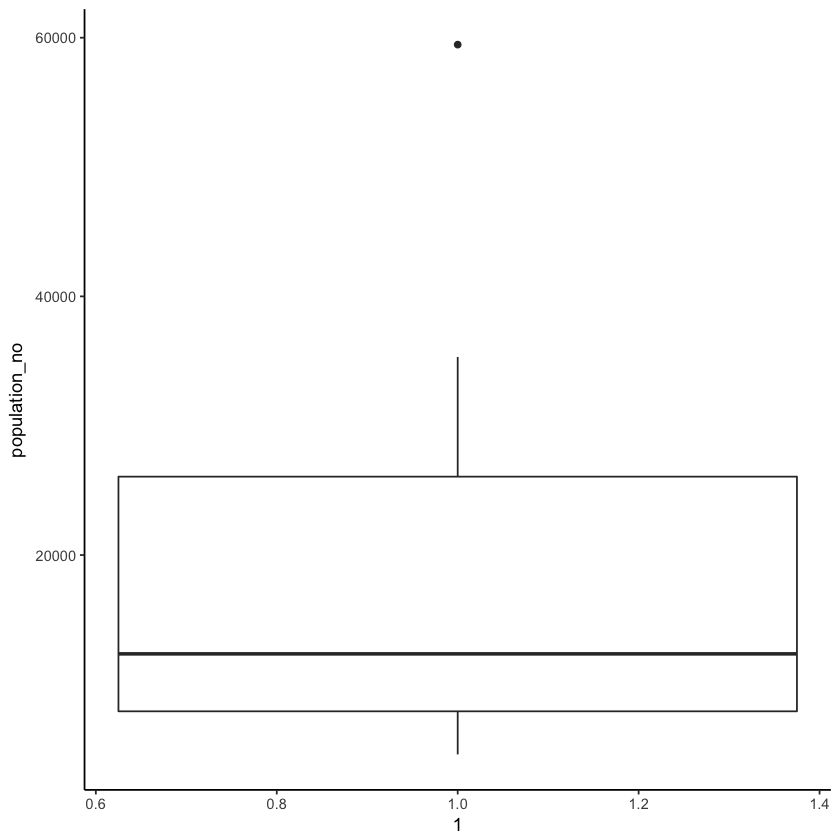

In [38]:
ggplot( df.comb, aes( x = 1, y = population_no ) ) +
    geom_boxplot() +
    theme_classic()

In [39]:
df.comb[which( df.comb$population_no > 40000 ),]

,city_nm,population_no,agg_sales_no,land_area_no,households_under_18_no,pop_density_no,total_families_no
3,Cheyenne,59466,917892,1500.178,7158,20.34,14612.64


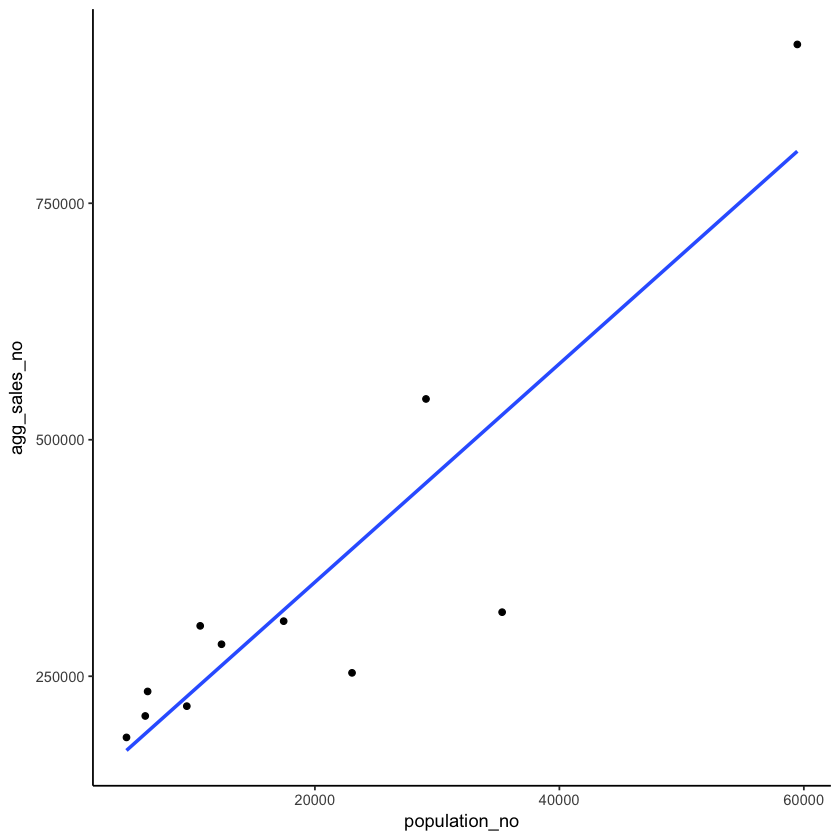

In [40]:
ggplot( df.comb, aes( x = population_no, y = agg_sales_no ) ) +
    geom_point() +
    geom_smooth( method = 'lm', se = FALSE ) +
    theme_classic()

Cheyenne population seems within the realm of possibility, reasonably within a linear model of the other data, and we may be predicting sales for other larger cities. Retained.

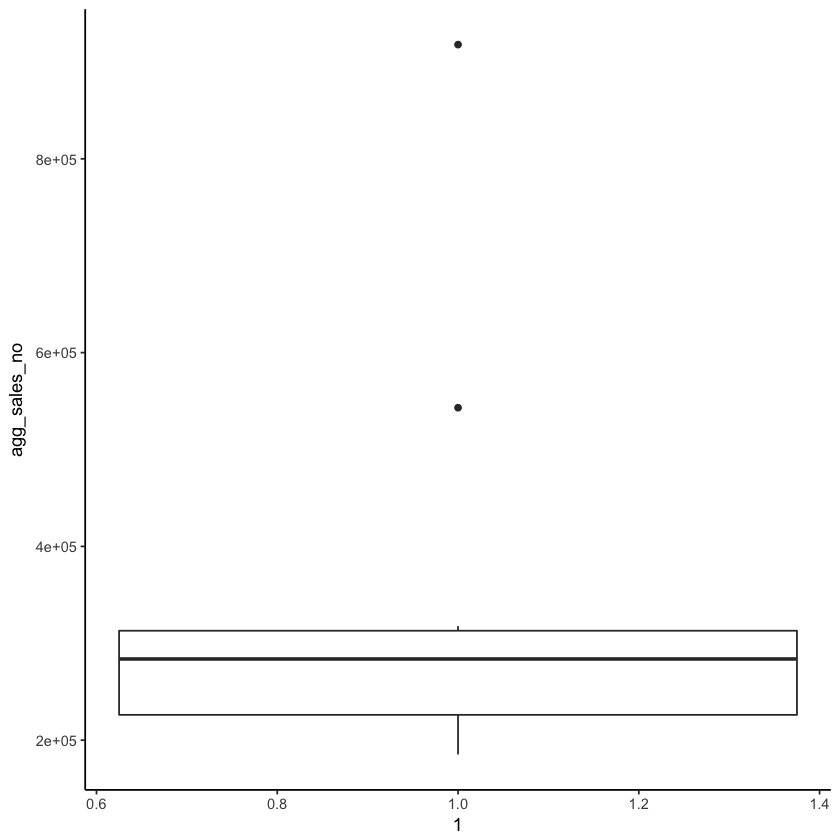

In [41]:
ggplot( df.comb, aes( x = 1, y = agg_sales_no ) ) +
    geom_boxplot() +
    theme_classic()

In [42]:
df.comb[which( df.comb$population_no > 30000 ),]

,city_nm,population_no,agg_sales_no,land_area_no,households_under_18_no,pop_density_no,total_families_no
2,Casper,35316,317736,3894.309,7788,11.16,8756.32
3,Cheyenne,59466,917892,1500.178,7158,20.34,14612.64


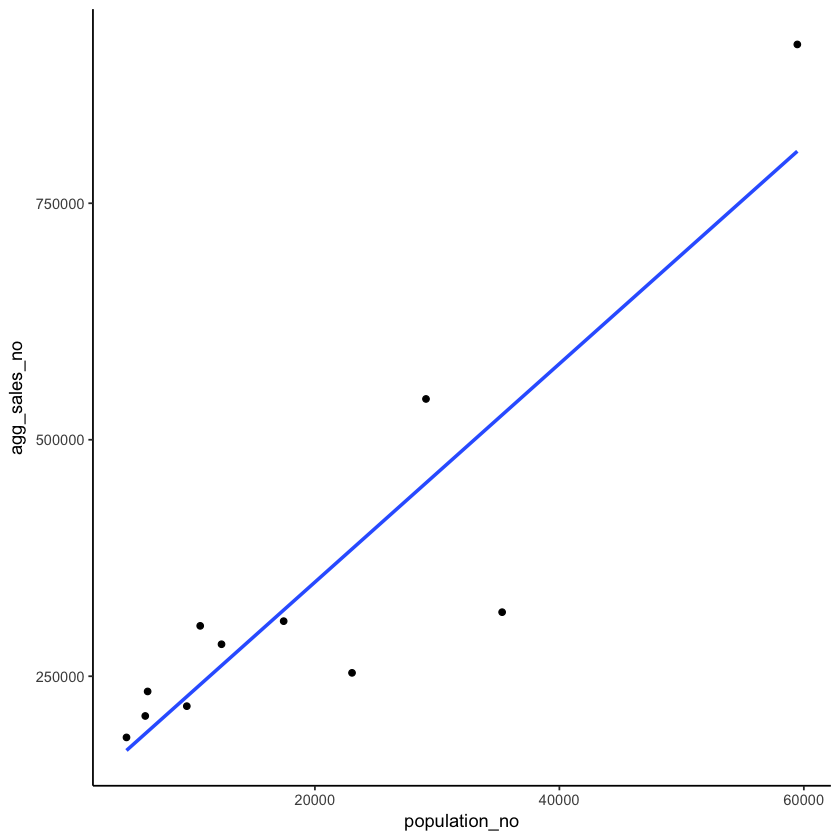

In [43]:
ggplot( df.comb, aes( x = population_no, y = agg_sales_no ) ) +
    geom_point() +
    geom_smooth( method = 'lm', se = FALSE ) +
    theme_classic()

Again, the population outliers are within possibility for large cities and fall in a linear model with agg_sales, so retained.

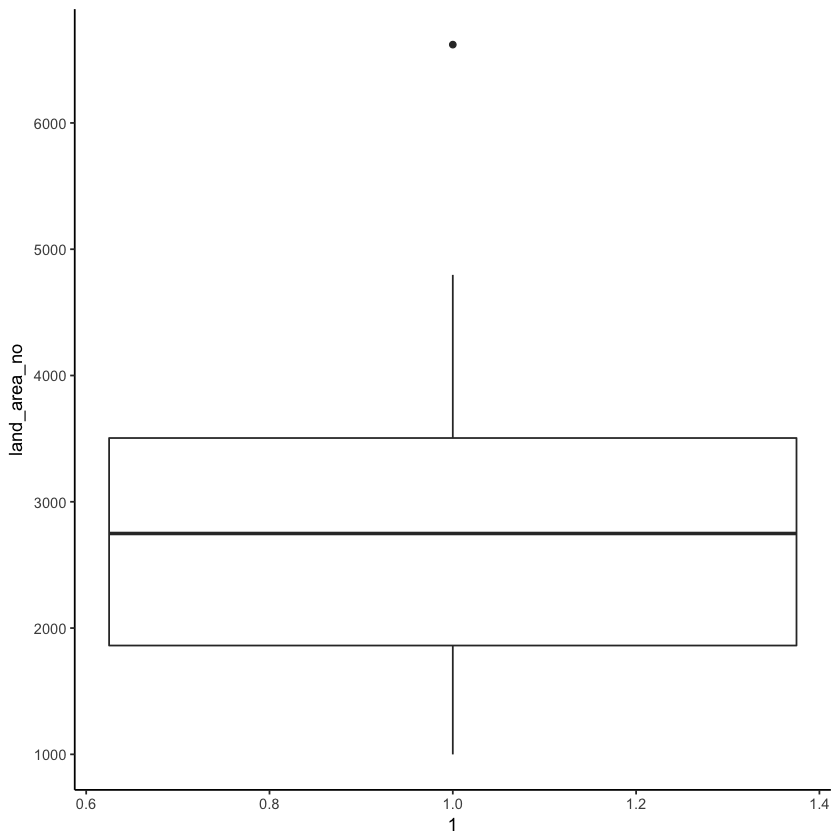

In [44]:
ggplot( df.comb, aes( x = 1, y = land_area_no ) ) +
    geom_boxplot() + 
    theme_classic()

In [45]:
df.comb[which( df.comb$land_area_no > 6000 ),]

,city_nm,population_no,agg_sales_no,land_area_no,households_under_18_no,pop_density_no,total_families_no
10,Rock Springs,23036,253584,6620.202,4022,2.78,7572.18


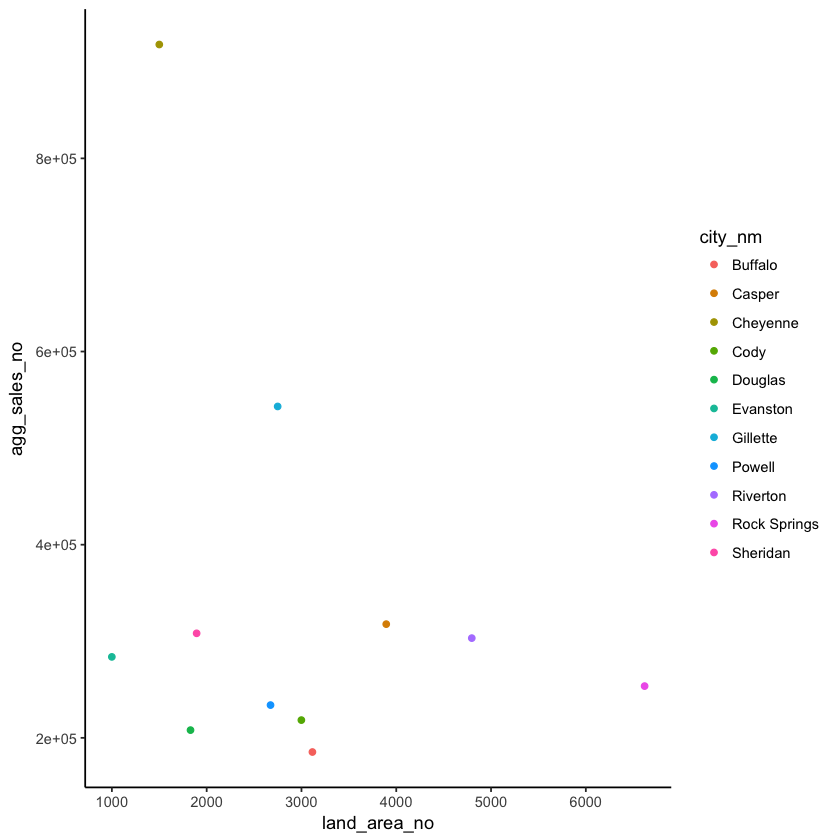

In [46]:
ggplot( df.comb, aes( x = land_area_no, y = agg_sales_no, color = city_nm ) ) +
    geom_point() +
    theme_classic()

Land area for Rock Springs doesn't seem too out of normal. Retained.

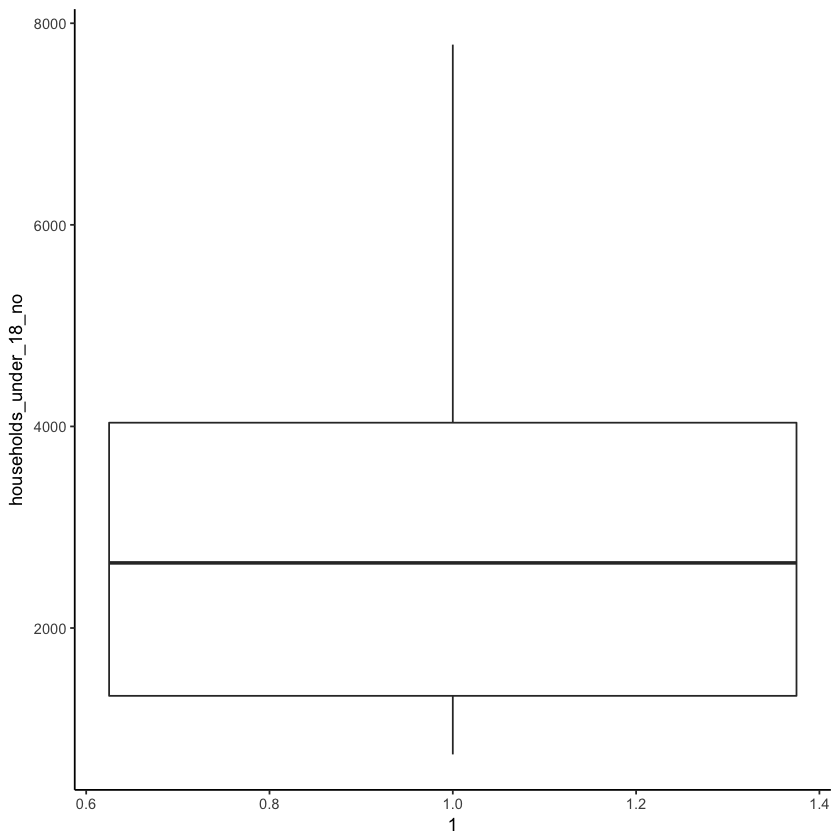

In [47]:
ggplot( df.comb, aes( x = 1, y = households_under_18_no ) ) +
    geom_boxplot() +
    theme_classic()

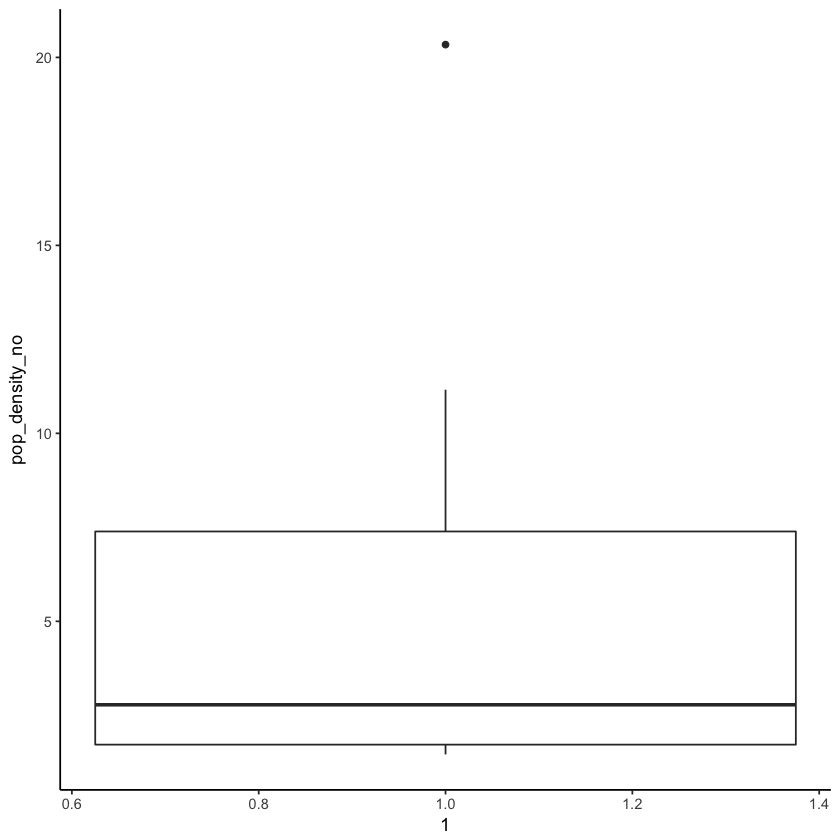

In [48]:
ggplot( df.comb, aes( x = 1, y = pop_density_no ) ) +
    geom_boxplot() + 
    theme_classic()

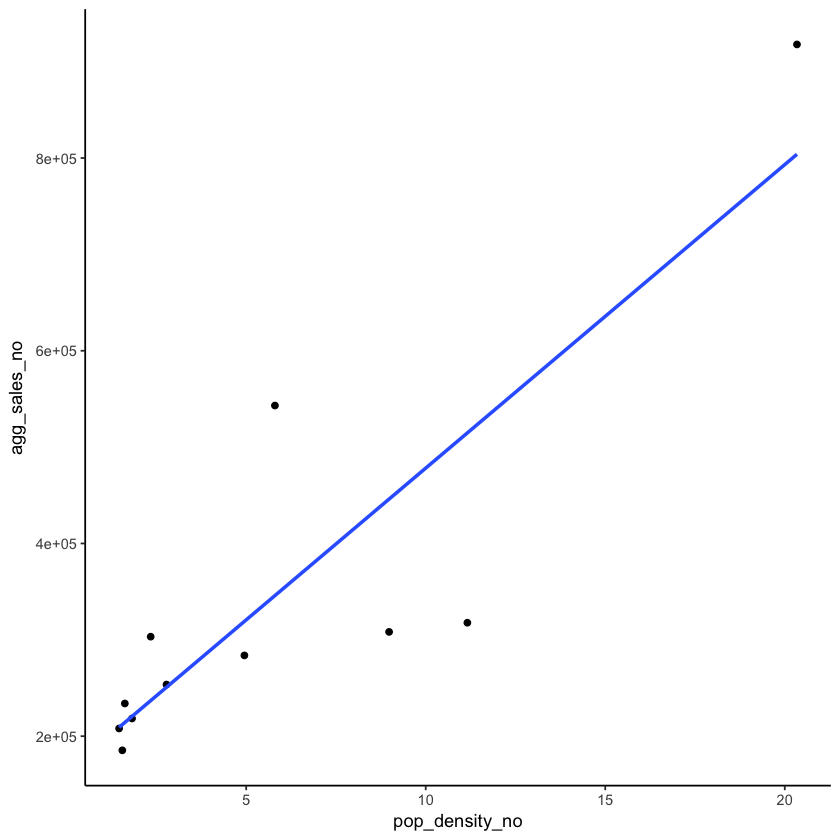

In [49]:
ggplot( df.comb, aes( x = pop_density_no, y = agg_sales_no ) ) +
    geom_point() +
    geom_smooth( method = 'lm', se = FALSE ) +
    theme_classic()

Here again, Cheyenne is a population density outlier, but falls in line with other cities when plotted against aggregate sales. Retained.

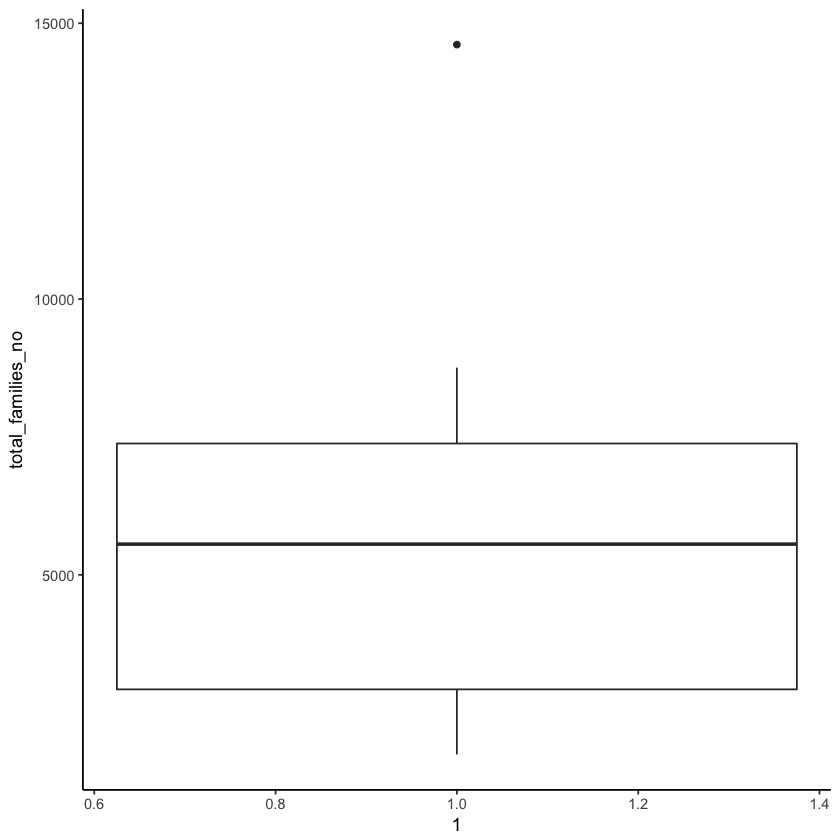

In [50]:
ggplot( df.comb, aes( x = 1, y = total_families_no ) ) +
    geom_boxplot() +
    theme_classic()

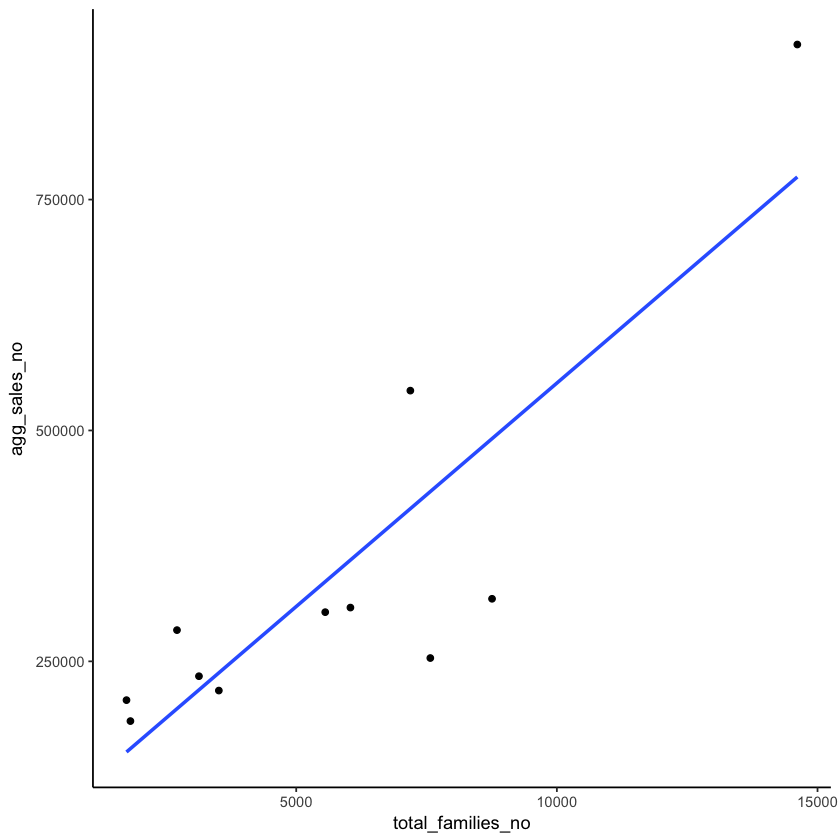

In [51]:
ggplot( df.comb, aes( x = total_families_no, y = agg_sales_no ) ) +
    geom_point() +
    geom_smooth( method = 'lm', se = FALSE ) +
    theme_classic()

### Are there any cities that are outliers in the dataset?
Cheyenne might be an outlier depending on if there are other candidate cities near the size and population density elsewhere in Wyoming. As it is, I would retain them until I look at the sizes of other cities under consideration.